In [2]:
# from glmhmm import *
import numpy as np
import sys
sys.path.append('/data/users/weixuan/work/model')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp

['/data/users/weixuan/work/model/glmhmm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python38.zip', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/lib-dynload', '', '/home/wliu25/.local/lib/python3.8/site-packages', '/data/users/weixuan/work/model/ssm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/setuptools/_vendor', '/data/users/weixuan/work/model']


/home/wliu25/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json
import os
import numpy as np

JSON_FILE = "metric_testing_model_data.json"  # Path to store results

def save_model_results(N, K, D, dim_output, A_true, w_true, pi0_true, true_states_seq, A_pred, w_pred, pi0_pred, pred_states_seq,\
    A_init, w_init, pi0_init, init_states_seq, true_states_seq_fit):
    """Save trained model parameters to JSON, appending to existing settings if present."""
    
    # Convert NumPy arrays to lists for JSON storage
    model_data = {
        "A_true": A_true.tolist(),
        "w_true": w_true.tolist(),
        "pi0_true": pi0_true.tolist(),
        "true_states_seq": true_states_seq.tolist(),
        "true_states_seq_fit": true_states_seq_fit.tolist(),

        "A_init": A_init.tolist(),
        "w_init": w_init.tolist(),
        "pi0_init": pi0_init.tolist(),
        "init_states_seq": init_states_seq.tolist(),

        "A_pred": A_pred.tolist(),
        "w_pred": w_pred.tolist(),
        "pi0_pred": pi0_pred.tolist(),
        "pred_states_seq": pred_states_seq.tolist(),
    }

    # Load existing JSON data
    if os.path.exists(JSON_FILE):
        with open(JSON_FILE, "r") as f:
            data = json.load(f)
    else:
        data = {}

    # Create a unique key based on (N, K, D, dim_output)
    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"

    # Append new model data to existing key or create a new entry
    if key in data:
        data[key].append(model_data)  # Append new model
    else:
        data[key] = [model_data]  # First model for this setting

    # Save back to JSON
    with open(JSON_FILE, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Saved model under {key} in {JSON_FILE}")

In [94]:
def train_and_store_model(N, K, D, dim_output, testN = 3000):
    """Train a model and store its parameters in JSON."""
    
    # Generate true model and data
    X, Y, _, A_true, w_true, pi0_true, m_true = gen_true_param(N, K, D, dim_output)
    X_test, Y_test, true_states_seq = m_true.generate_data(testN)
    true_states_seq_fit = m_true.mostprob_states(X_test, Y_test).astype(int)

    # Train model
    m = GLMHMM(N, K, D, dim_output, 1.0)

    A_init=m.transition_matrix.copy()
    w_init=m.w.copy()
    pi0_init  = m.pi0.copy()
    init_states_seq = m.mostprob_states(X_test, Y_test).astype(int)

    lls_pred, A_pred, w_pred, pi0_pred = m.fit(Y, X, np.copy(A_init), np.copy(w_init), pi0=np.copy(pi0_init), fit_init_states=True)
    pred_states_seq = m.mostprob_states(X_test, Y_test).astype(int)

    # Save the trained model's results
    save_model_results(N, K, D, dim_output, A_true, w_true, pi0_true, true_states_seq, A_pred, w_pred, pi0_pred, pred_states_seq,\
         A_init, w_init, pi0_init, init_states_seq, true_states_seq_fit)

In [4]:
def load_models(N, K, D, dim_output):
    """Load all stored models for a given setting."""
    
    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"
    
    # Load JSON data
    if not os.path.exists(JSON_FILE):
        print("No saved models found.")
        return None
    
    with open(JSON_FILE, "r") as f:
        data = json.load(f)

    if key not in data:
        print(f"No models found for {key}")
        return None
    
    return data[key]

In [9]:
def metric_comp(storage_all, colormap = "cividis"):
    storage_all #(true, pred, true to init/pred, metric)
    metrics = ["A element", "A vector", "w element", "w vector", "accuracy", "precision", "recall", "f1", "match rate"]

    fig, axes = plt.subplots(len(metrics), 3, figsize=(12, 36))
    fig.tight_layout(pad=4.0)

    # Iterate through metrics and subplots
    for idx, metric in enumerate(metrics):
        # Extract data for the current metric
        true2init = storage_all[:, :, 0, idx]
        true2pred = storage_all[:, :, 1, idx]

        # true vs true fit(state seq only) at place index 4, 5, 6, 7
        accuracy_true2tf = storage_all[:, :, 2, 4]
        precision_true2tf = storage_all[:, :, 2, 5]
        recall_true2tf = storage_all[:, :, 2, 6]
        f1_true2tf = storage_all[:, :, 2, 7]

        # Compute vmin and vmax for the current row (shared between true2init and true2pred)
        vmin = min(true2init.min(), true2pred.min())
        vmax = max(true2init.max(), true2pred.max())

        if idx == 1:
            true2true = storage_all[:, :, 2, idx]
            vmin = min(vmin, true2true.min())
            vmax = max(vmax, true2true.max())

        # Plot true-to-init
        ax_init = axes[idx, 0]
        c1 = ax_init.imshow(true2init, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
        ax_init.set_title(f"{metric} - True vs Init")
        fig.colorbar(c1, ax=ax_init)
        # Add text annotations for each value
        for i in range(true2init.shape[0]):
            for j in range(true2init.shape[1]):
                ax_init.text(j, i, f"{true2init[i, j]:.2f}", ha='center', va='center', color='white')

        # Plot true-to-pred
        ax_pred = axes[idx, 1]
        c2 = ax_pred.imshow(true2pred, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f"{metric} - True vs Pred")
        fig.colorbar(c2, ax=ax_pred)
        # Add text annotations for each value
        for i in range(true2pred.shape[0]):
            for j in range(true2pred.shape[1]):
                ax_pred.text(j, i, f"{true2pred[i, j]:.2f}", ha='center', va='center', color='white')

        # Plot true-to-true
        if idx == 1:
            ax_pred = axes[idx, 2]
            c2 = ax_pred.imshow(true2true, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
            ax_pred.set_title(f"{metric} - True vs True")
            fig.colorbar(c2, ax=ax_pred)
            # Add text annotations for each value
            for i in range(true2true.shape[0]):
                for j in range(true2true.shape[1]):
                    ax_pred.text(j, i, f"{true2true[i, j]:.2f}", ha='center', va='center', color='white')

        if idx == 4:
            ax_pred = axes[idx, 2]
            c2 = ax_pred.imshow(accuracy_true2tf, aspect='auto', cmap=colormap, vmin=np.min(accuracy_true2tf), vmax=np.max(accuracy_true2tf))
            ax_pred.set_title(f"{metric} - True vs True_fit")
            fig.colorbar(c2, ax=ax_pred)
            # Add text annotations for each value
            for i in range(accuracy_true2tf.shape[0]):
                for j in range(accuracy_true2tf.shape[1]):
                    ax_pred.text(j, i, f"{accuracy_true2tf[i, j]:.2f}", ha='center', va='center', color='white')

        if idx == 5:
            ax_pred = axes[idx, 2]
            c2 = ax_pred.imshow(precision_true2tf, aspect='auto', cmap=colormap, vmin=np.min(precision_true2tf), vmax=np.max(precision_true2tf))
            ax_pred.set_title(f"{metric} - True vs True_fit")
            fig.colorbar(c2, ax=ax_pred)
            # Add text annotations for each value
            for i in range(precision_true2tf.shape[0]):
                for j in range(precision_true2tf.shape[1]):
                    ax_pred.text(j, i, f"{precision_true2tf[i, j]:.2f}", ha='center', va='center', color='white')

        if idx == 6:
            ax_pred = axes[idx, 2]
            c2 = ax_pred.imshow(recall_true2tf, aspect='auto', cmap=colormap, vmin=np.min(recall_true2tf), vmax=np.max(recall_true2tf))
            ax_pred.set_title(f"{metric} - True vs True_fit")
            fig.colorbar(c2, ax=ax_pred)
            # Add text annotations for each value
            for i in range(recall_true2tf.shape[0]):
                for j in range(recall_true2tf.shape[1]):
                    ax_pred.text(j, i, f"{recall_true2tf[i, j]:.2f}", ha='center', va='center', color='white')

        if idx == 7:
            ax_pred = axes[idx, 2]
            c2 = ax_pred.imshow(f1_true2tf, aspect='auto', cmap=colormap, vmin=np.min(f1_true2tf), vmax=np.max(f1_true2tf))
            ax_pred.set_title(f"{metric} - True vs True_fit")
            fig.colorbar(c2, ax=ax_pred)
            # Add text annotations for each value
            for i in range(f1_true2tf.shape[0]):
                for j in range(f1_true2tf.shape[1]):
                    ax_pred.text(j, i, f"{f1_true2tf[i, j]:.2f}", ha='center', va='center', color='white')

        
                
    # Add overall figure title
    fig.suptitle("Metric Visualization", fontsize=16, y=1.02)

    # Display the plots
    plt.show()


In [5]:
import numpy as np
import json
import os

def analyze_stored_models(N, K, D, dim_output, verbose=False):
    """Load and compare all stored models for a given setting."""

    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"
    stored_models = load_models(N, K, D, dim_output)
    
    if stored_models is None:
        return None

    num_models = len(stored_models)

    print(f"Analyzing {num_models} models for {key}")

    # Initialize storage for metrics
    storage_all = np.zeros((num_models, num_models, 3, 9))  # 2: init-0, pred-1 # (true, pred, true to init/pred/true, metric)

    # Loop through all pairs of models for comparison
    for true_i in range(num_models):
        for pred_i in range(num_models):
            # Extract the true model parameters
            true_states_seq = np.array(stored_models[true_i]["true_states_seq"])
            true_states_seq_fit = np.array(stored_models[true_i]["true_states_seq_fit"])
            A_true = np.array(stored_models[true_i]["A_true"])
            w_true = np.array(stored_models[true_i]["w_true"])

            # Extract the predicted model init parameters
            init_states_seq = np.array(stored_models[pred_i]["init_states_seq"])
            A_init = np.array(stored_models[pred_i]['A_init'])
            w_init = np.array(stored_models[pred_i]['w_init'])

            # Extract the predicted model parameters
            pred_states_seq = np.array(stored_models[pred_i]["pred_states_seq"])
            A_pred = np.array(stored_models[pred_i]["A_pred"])
            w_pred = np.array(stored_models[pred_i]["w_pred"])

            # Extract the 2nd model parameters
            true_states_seq2 = np.array(stored_models[pred_i]["true_states_seq"])
            A_true2 = np.array(stored_models[pred_i]["A_true"])

            # Align state sequences using permutation
            perm_init = find_permutation(init_states_seq, true_states_seq)
            init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(len(init_states_seq))])
            A_perm_init = A_init[np.ix_(perm_init, perm_init)]
            w_perm_init = w_init[perm_init, :, :]

            perm = find_permutation(pred_states_seq, true_states_seq)
            pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(len(true_states_seq))])
            A_perm = A_pred[np.ix_(perm, perm)]
            w_perm = w_pred[perm, :, :]

            perm2 = find_permutation(true_states_seq2, true_states_seq)
            A_perm2 = A_true2[np.ix_(perm2, perm2)]

            # vis
            if verbose:
                if true_i == pred_i:
                    plt.figure(figsize=(12, 4))
                    plt.title(f"true{true_i}, pred{pred_i}")
                    plt.plot(range(200), pred_states_perm[:200], 'red', '--o', label='pred')
                    plt.plot(range(200), true_states_seq[:200], 'blue', '-o', label = 'true')
                    plt.plot(range(200), true_states_seq_fit[:200], 'gray', '--', label = "true_fit")
                    plt.legend()

            # Compute Metrics
            # Matrix comparison
            A_true2true_vector = matrix_comp(A_true, A_perm2, metric="vector")

            A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
            A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
            A_true2init_element = matrix_comp(A_true, A_perm_init, metric="element")
            A_true2init_vector = matrix_comp(A_true, A_perm_init, metric="vector")

            w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
            w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
            w_true2init_element = matrix_comp(w_true, w_perm_init, metric="element")
            w_true2init_vector = matrix_comp(w_true, w_perm_init, metric="vector")

            # State seq evaluation
            res_map_true2tf = evaluate_classification(true_states_seq_fit, true_states_seq)
            accuracy_true2tf = res_map_true2tf['accuracy']
            precision_true2tf = res_map_true2tf['precision']
            recall_true2tf = res_map_true2tf['recall']
            f1_true2tf = res_map_true2tf['f1_score']

            res_map_true2pred = evaluate_classification(pred_states_perm, true_states_seq)
            accuracy_true2pred = res_map_true2pred['accuracy'] #4
            precision_true2pred = res_map_true2pred['precision'] #5
            recall_true2pred = res_map_true2pred['recall'] #6
            f1_true2pred = res_map_true2pred['f1_score'] #7

            res_map_true2init = evaluate_classification(init_states_perm, true_states_seq)
            accuracy_true2init = res_map_true2init['accuracy']
            precision_true2init = res_map_true2init['precision']
            recall_true2init = res_map_true2init['recall']
            f1_true2init = res_map_true2init['f1_score']

            # matching rate of state seq
            mat_rate_true2pred = calculate_match_rate(pred_states_perm, true_states_seq) #8
            mat_rate_true2init = calculate_match_rate(init_states_perm, true_states_seq)

            # Storage
            # true vs init
            storage_all[true_i, pred_i, 0] = np.array([A_true2init_element, A_true2init_vector, w_true2init_element, w_true2init_vector, \
                accuracy_true2init, precision_true2init, recall_true2init, f1_true2init, mat_rate_true2init])

            # true vs pred
            storage_all[true_i, pred_i, 1] = np.array([A_true2pred_element, A_true2pred_vector, w_true2pred_element, w_true2pred_vector, \
                accuracy_true2pred, precision_true2pred, recall_true2pred, f1_true2pred, mat_rate_true2pred])

            # true vs true (A only)
            storage_all[true_i, pred_i, 2, 1] = A_true2true_vector

            # true vs true fit(state seq only) at place index 4, 5, 6, 7
            if true_i == pred_i:
                storage_all[true_i, pred_i, 2, 4] = accuracy_true2tf
                storage_all[true_i, pred_i, 2, 5] = precision_true2tf
                storage_all[true_i, pred_i, 2, 6] = recall_true2tf
                storage_all[true_i, pred_i, 2, 7] = f1_true2tf
            
    # Save analysis results
    analysis_file = "metric_testing_analysis_results.json"
    analysis_results = {key: storage_all.tolist()}

    with open(analysis_file, "w") as f:
        json.dump(analysis_results, f, indent=4)

    print(f"Analysis saved to {analysis_file}")
    return storage_all


In [104]:
# N=500
# dim_output=2
# D = 7
# K = 2
for _ in range(3):
    N=500
    dim_output=2
    D = 7
    K = 2
    train_and_store_model(N, K, D, dim_output)
for _ in range(5):
    N=1000
    dim_output=2
    D = 7
    K = 2
    train_and_store_model(N, K, D, dim_output)

for _ in range(5):
    N=2000
    dim_output=2
    D = 7
    K = 2
    train_and_store_model(N, K, D, dim_output)

for _ in range(5):
    N=2000
    dim_output=2
    D = 7
    K = 3
    train_and_store_model(N, K, D, dim_output)
# storage_all = analyze_stored_models(N, K, D, dim_output, True)
# storage_all

/data/users/weixuan/work/model/glmhmm/glmhmm.py:457: RuntimeWarning: divide by zero encountered in log
  log_probs[0] = np.log(self._compute_likelihood(X_augmented[0], Y[0])) + np.log(1 / self.n_states)
/data/users/weixuan/work/model/glmhmm/glmhmm.py:462: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))
/data/users/weixuan/work/model/glmhmm/glmhmm.py:464: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))


Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Iter11
Iter12
Saved model under N=500_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Saved model under N=500_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Saved model under N=500_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3


/data/users/weixuan/work/model/glmhmm/glmhmm.py:315: RuntimeWarning: divide by zero encountered in log
  ll_list = [gammak[i] * np.log(self.dist_pdf(y[i], thetak[i], otherparamk=otherparamk)) for i in range(self.N)]
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Iter4
Iter5
Iter6
Iter7
Iter8
Saved model under N=1000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Saved model under N=1000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Saved model under N=1000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Saved model under N=1000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Saved model under N=1000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Saved model under N=2000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Saved model under N=2000_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Saved model under N=2000_K=2_D=7_dim_output

Analyzing 5 models for N=500_K=2_D=7_dim_output=2


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-

Analysis saved to metric_testing_analysis_results.json


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[[0.28035763, 0.15812103, 8.50038825, 1.44307755, 0.677     ,
          0.92193346, 0.677     , 0.76549037, 0.677     ],
         [0.54172713, 0.28703433, 0.25460461, 0.21994763, 0.775     ,
          0.7748445 , 0.775     , 0.77050699, 0.775     ],
         [0.        , 0.        , 0.        , 0.        , 0.83233333,
          0.83065434, 0.83233333, 0.83096495, 0.        ]],

        [[0.43612529, 0.23972338, 3.65398618, 1.31567591, 0.64766667,
          0.92256501, 0.64766667, 0.75525451, 0.64766667],
         [0.53658326, 0.28239231, 6.77416511, 1.62221117, 0.58133333,
          0.6086913 , 0.58133333, 0.59314429, 0.58133333],
         [0.        , 0.09186281, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        ]],

        [[0.16529833, 0.07757908, 8.95131221, 1.51858223, 0.66433333,
          1.        , 0.66433333, 0.79831764, 0.66433333],
         [0.49893761, 0.30336459, 4.74253771, 0.63853908, 0.515     ,
          0.50234698, 0

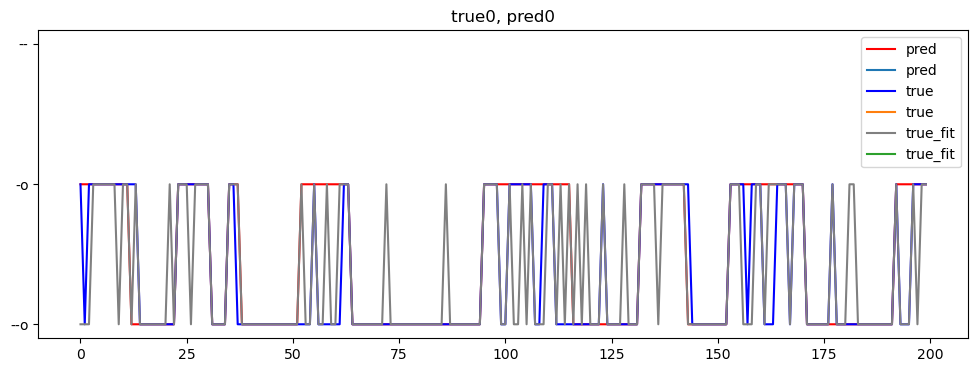

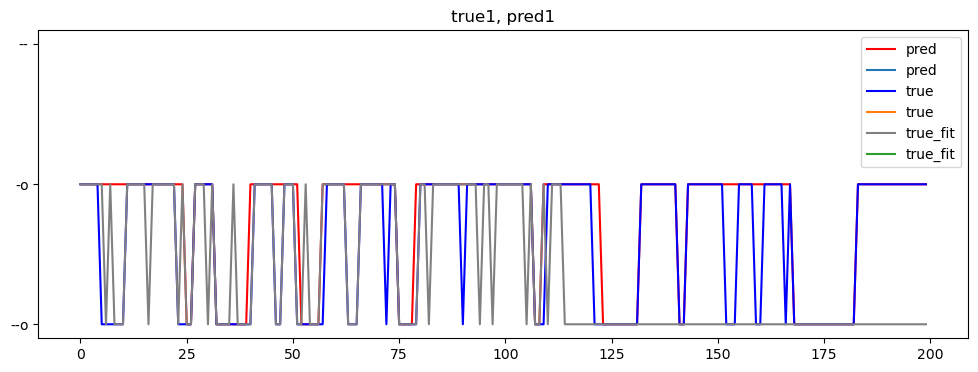

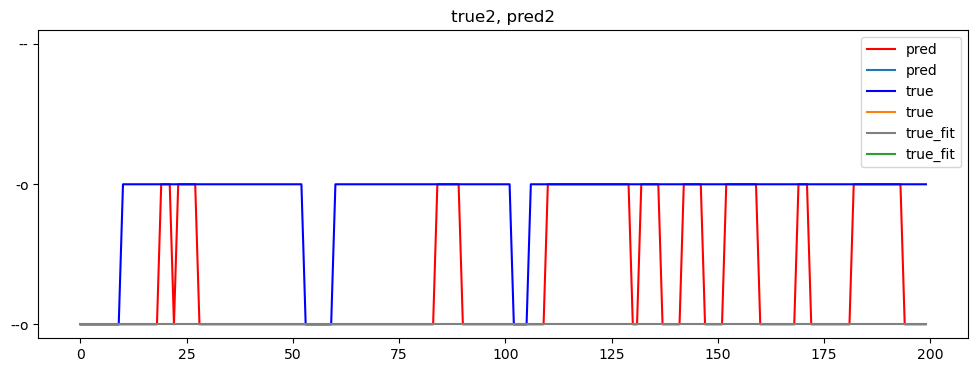

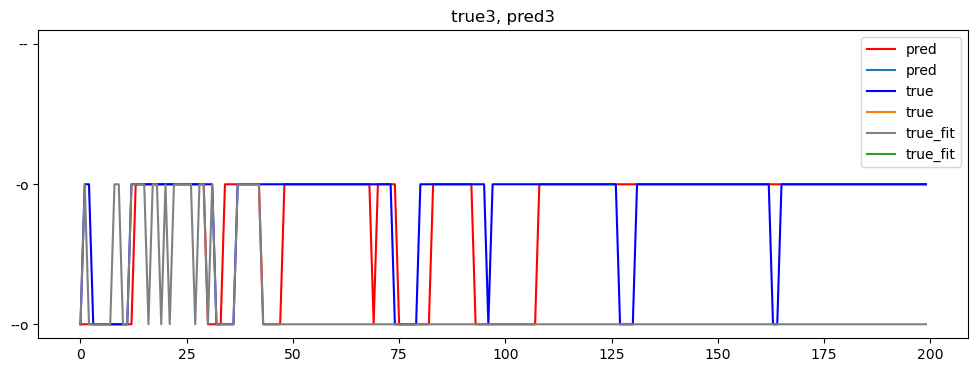

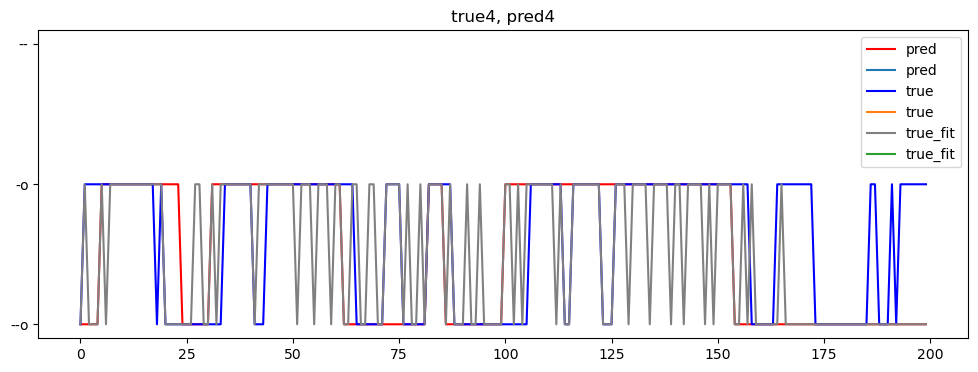

In [6]:
N=500
dim_output=2
D = 7
K = 2
storage_all = analyze_stored_models(N, K, D, dim_output, True)
storage_all

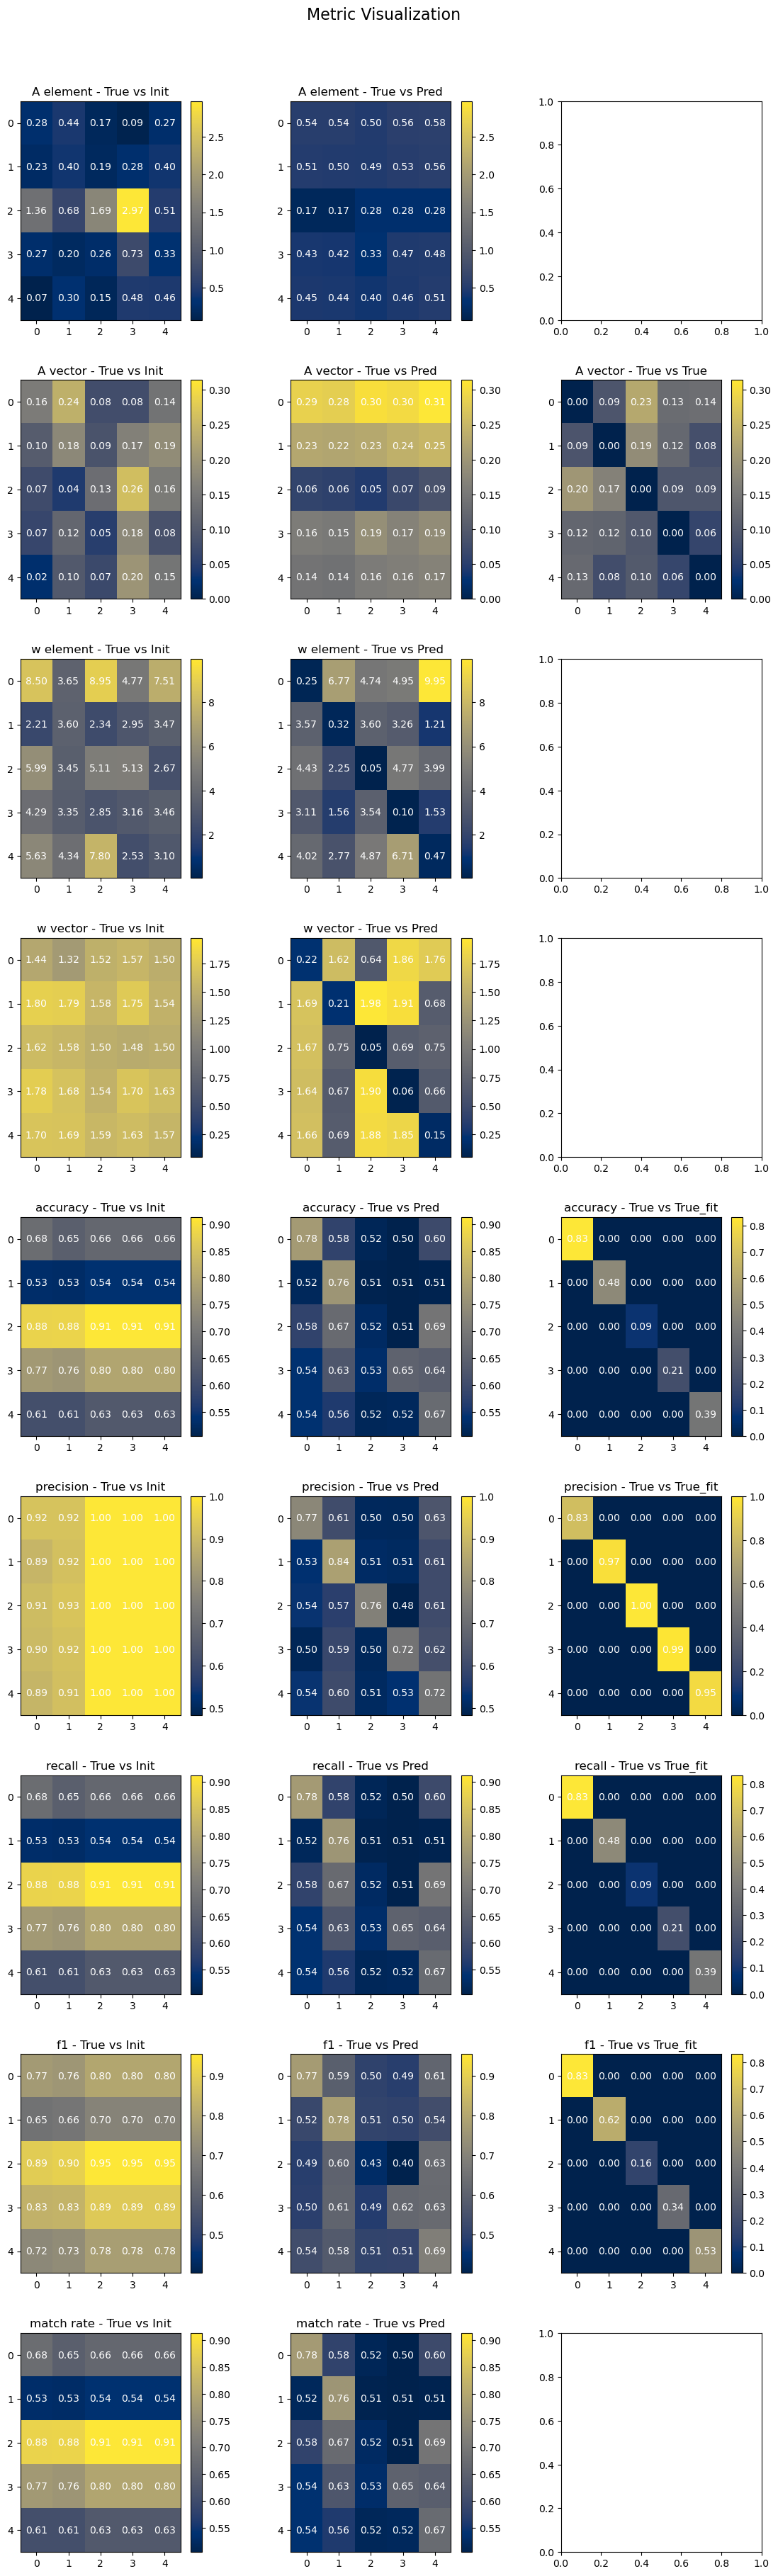

In [10]:
metric_comp(storage_all)

Analyzing 5 models for N=1000_K=2_D=7_dim_output=2


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-

Analysis saved to metric_testing_analysis_results.json


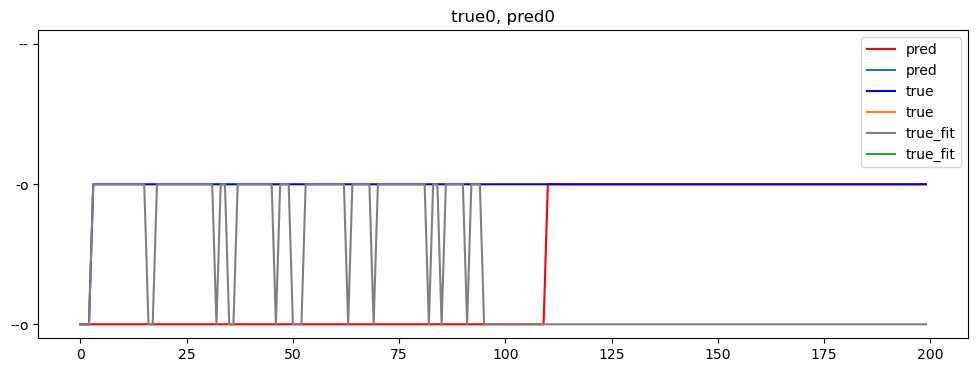

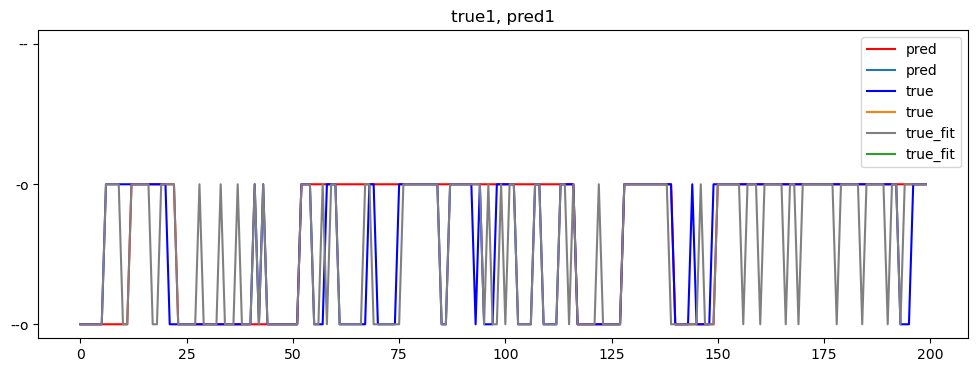

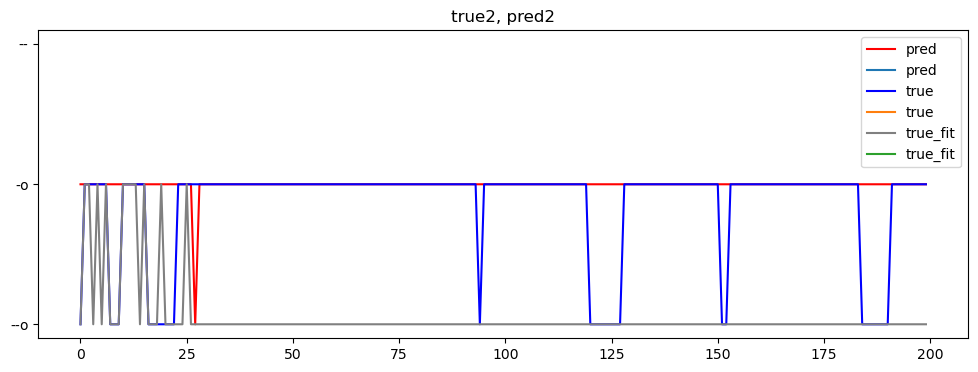

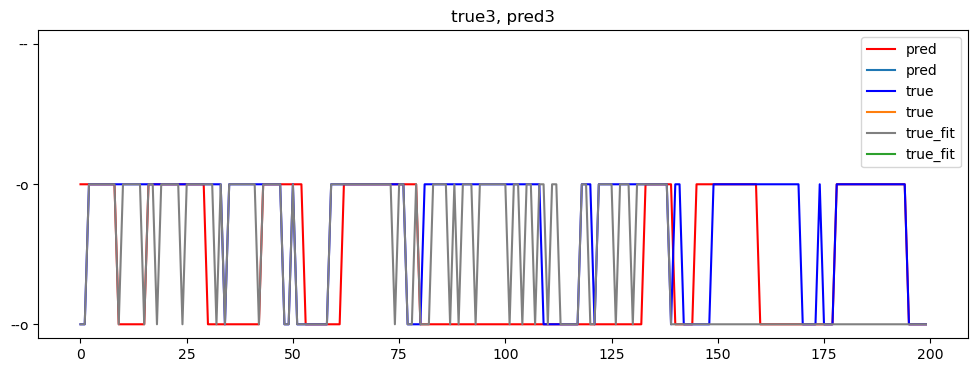

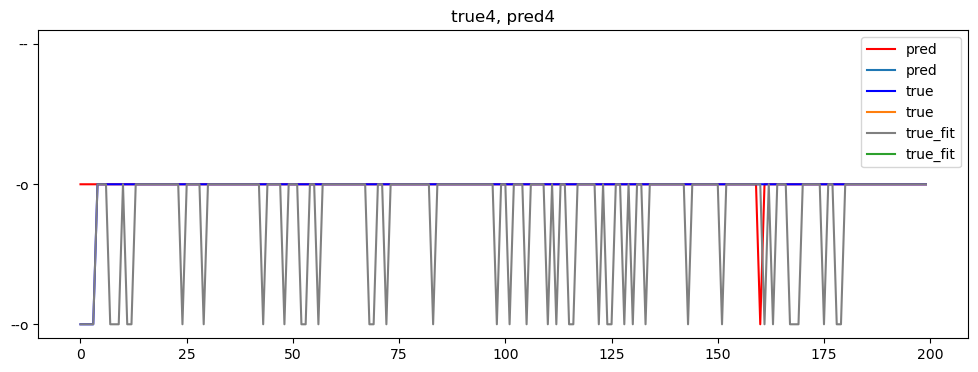

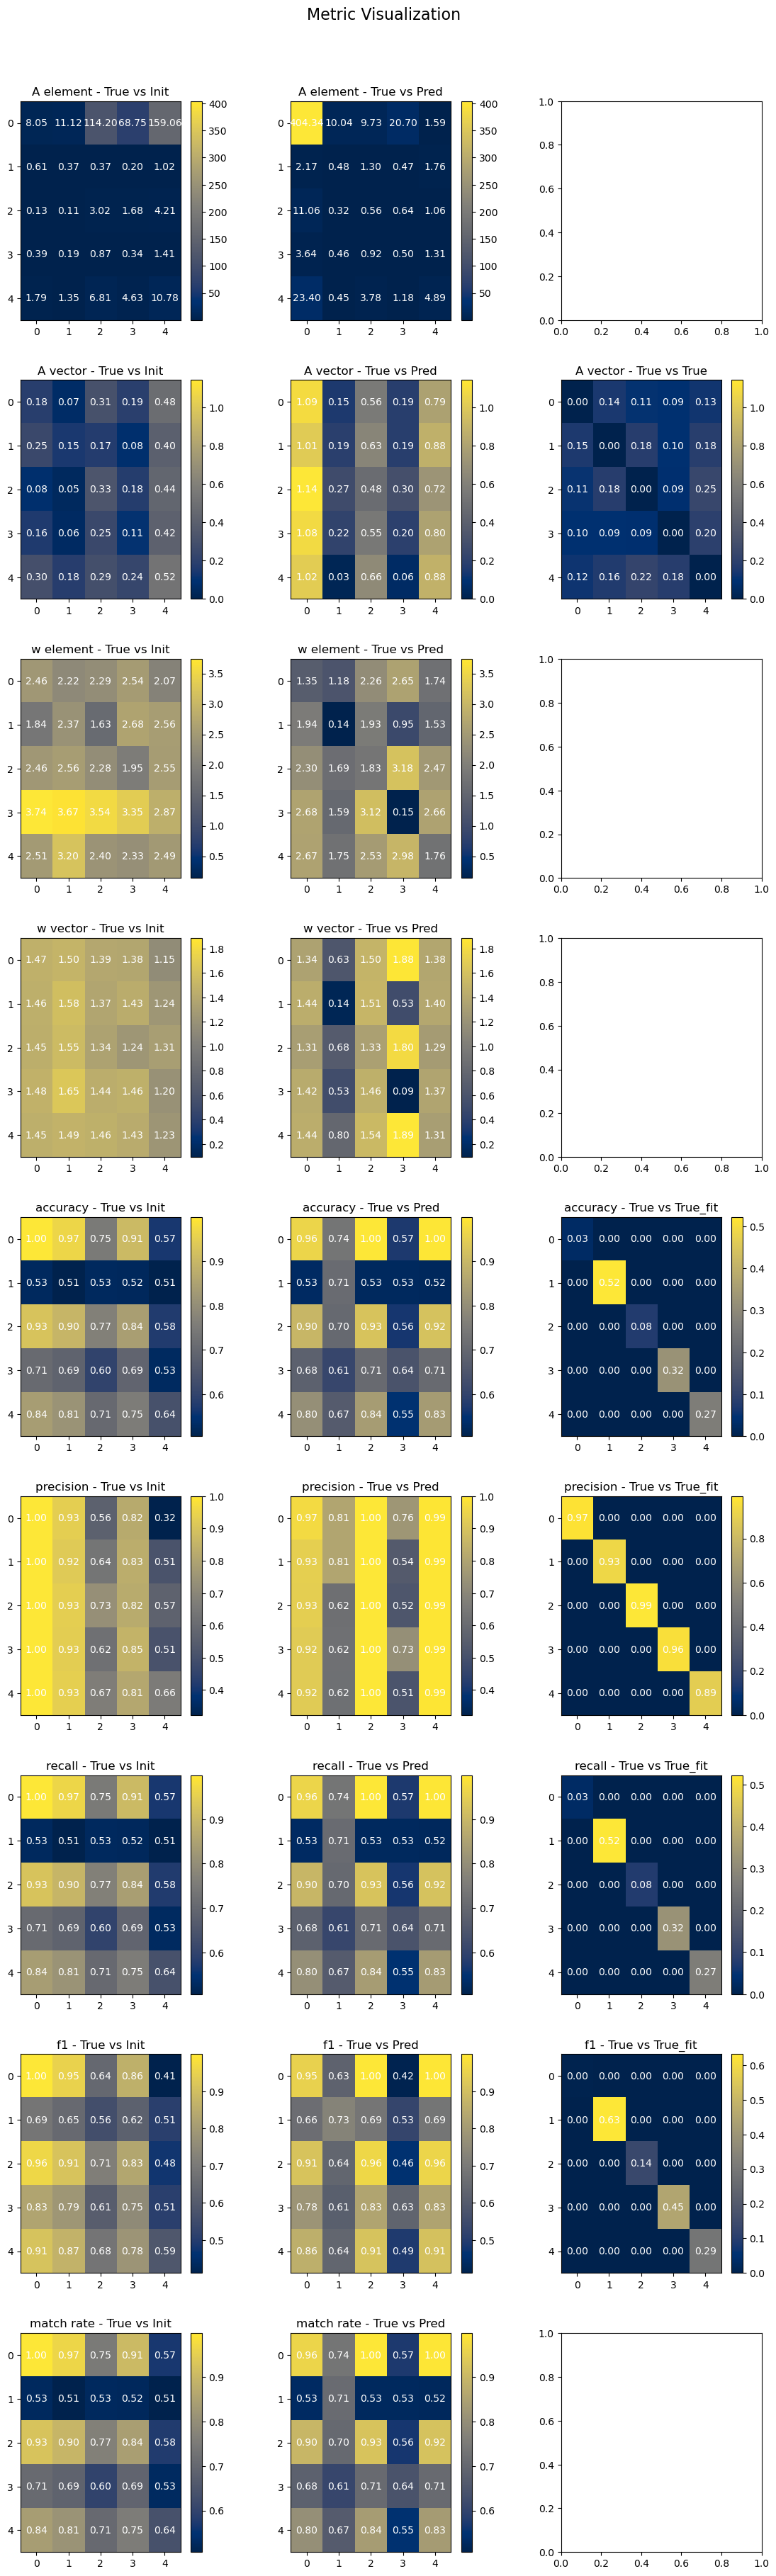

In [11]:
N=1000
dim_output=2
D = 7
K = 2
storage_all = analyze_stored_models(N, K, D, dim_output, True)
metric_comp(storage_all)

Analyzing 5 models for N=2000_K=2_D=7_dim_output=2
Analysis saved to metric_testing_analysis_results.json


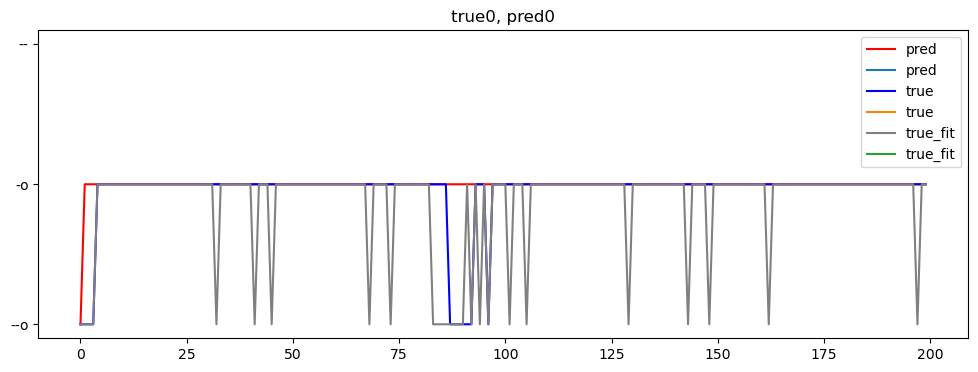

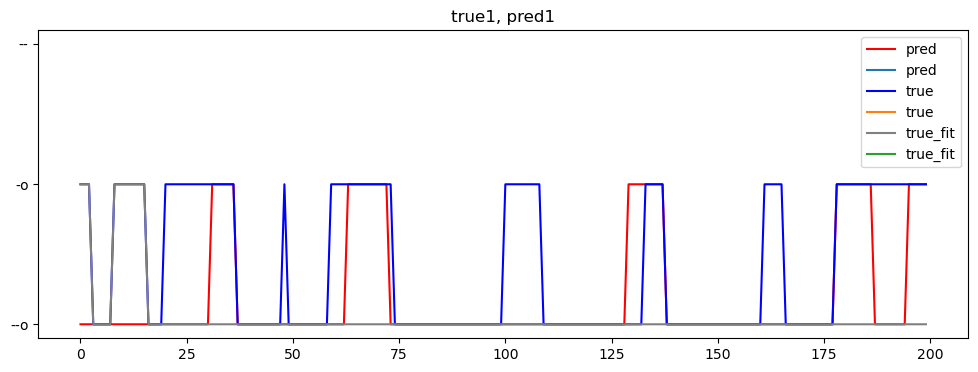

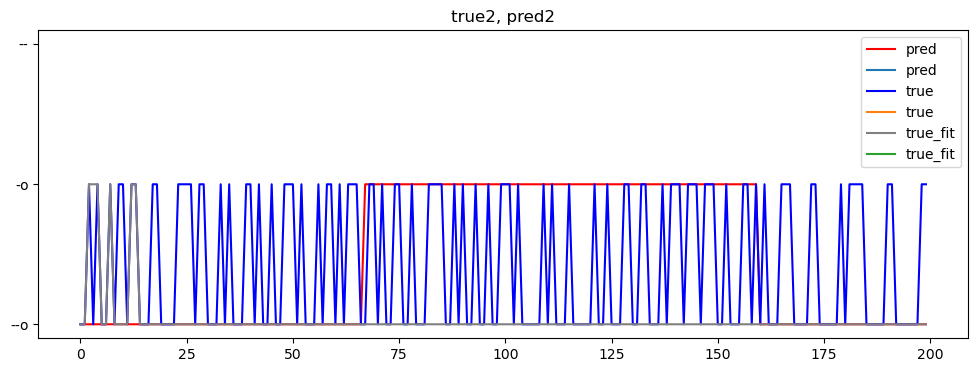

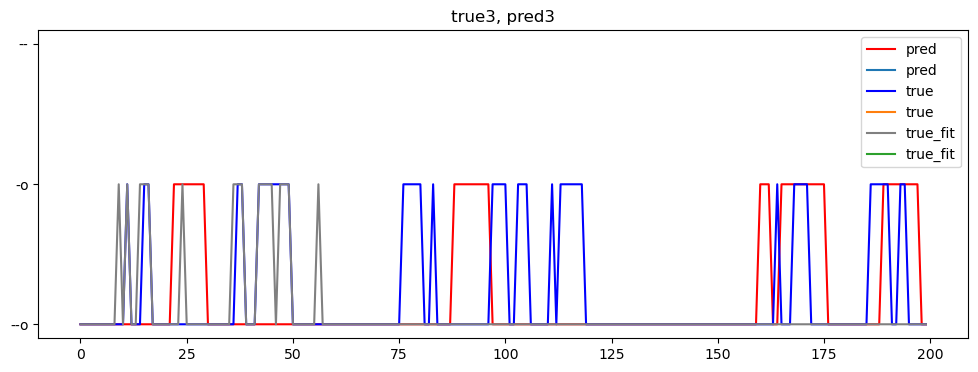

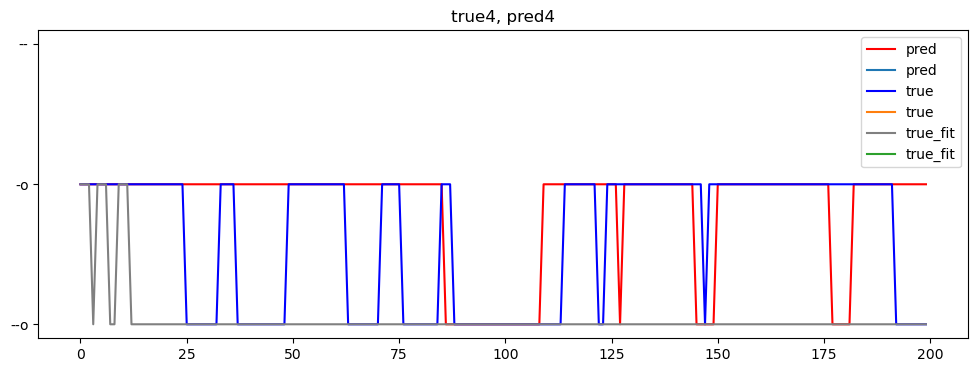

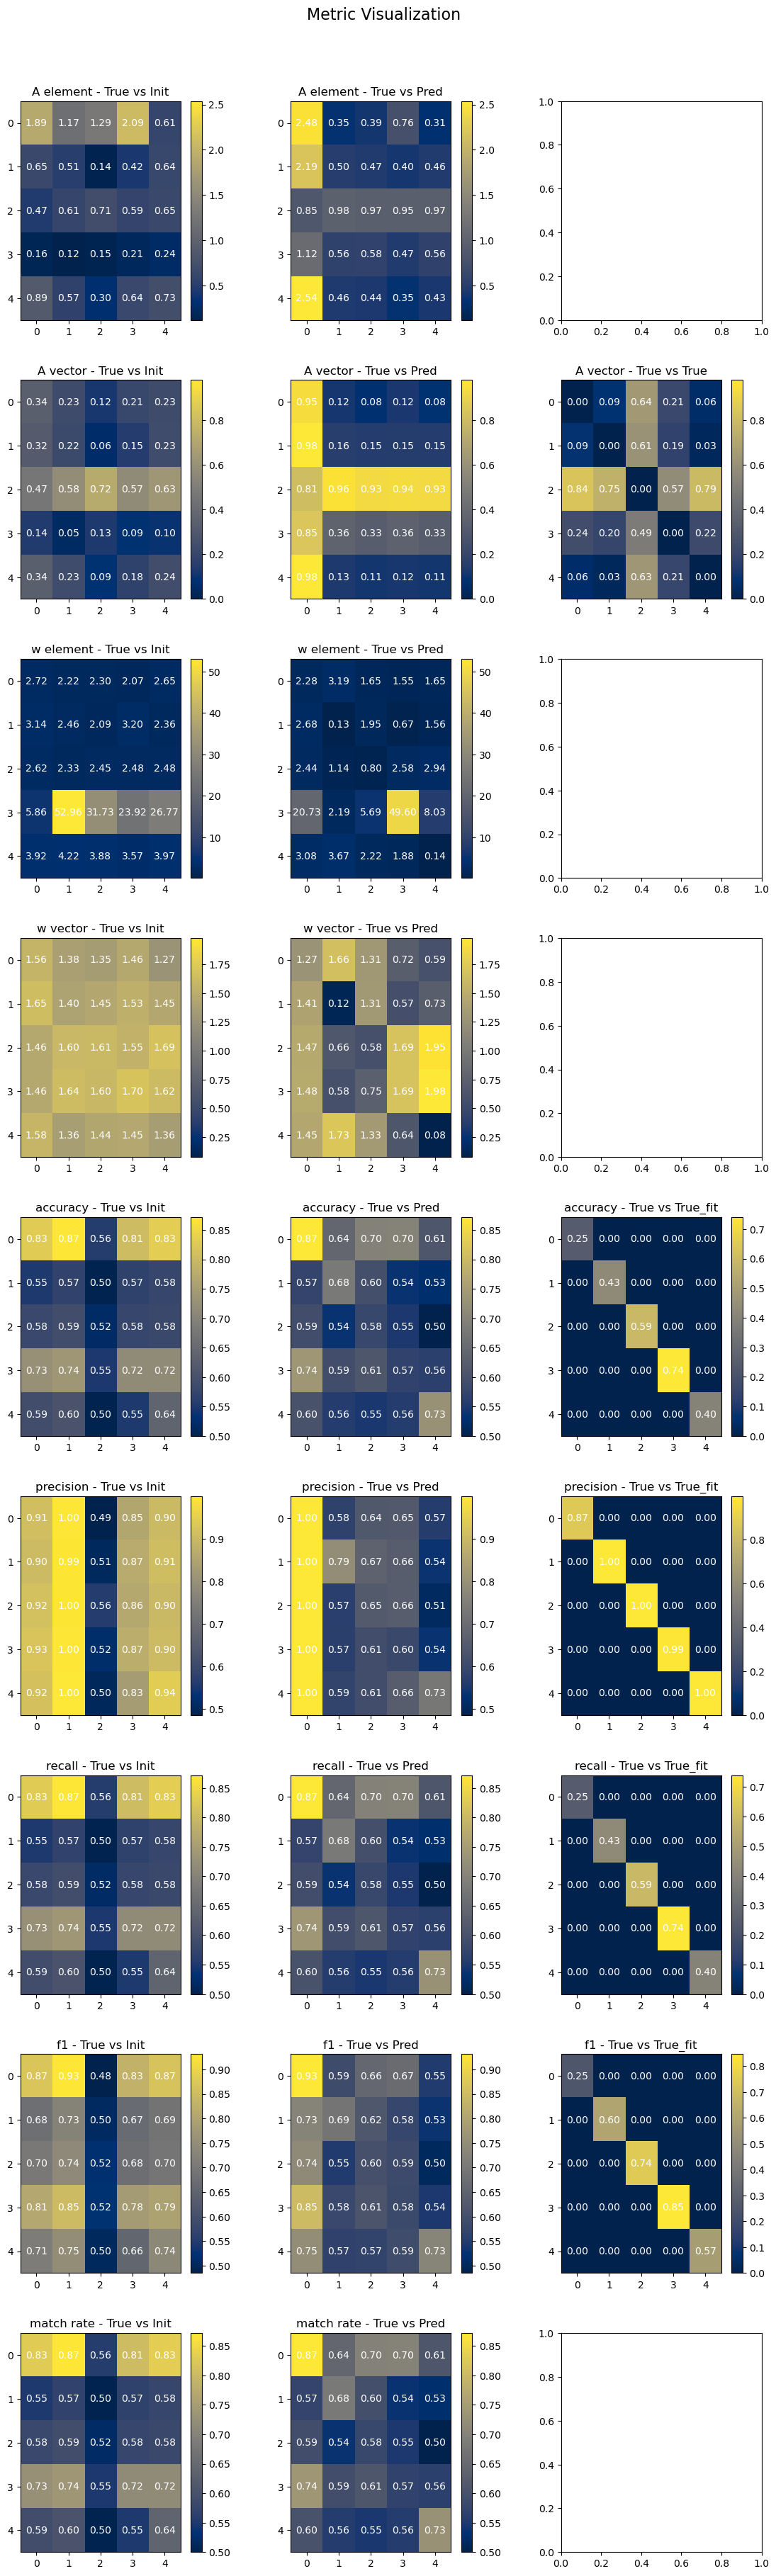

In [12]:
N=2000
dim_output=2
D = 7
K = 2
storage_all = analyze_stored_models(N, K, D, dim_output, True)
metric_comp(storage_all)

Analyzing 5 models for N=2000_K=3_D=7_dim_output=2


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-

Analysis saved to metric_testing_analysis_results.json


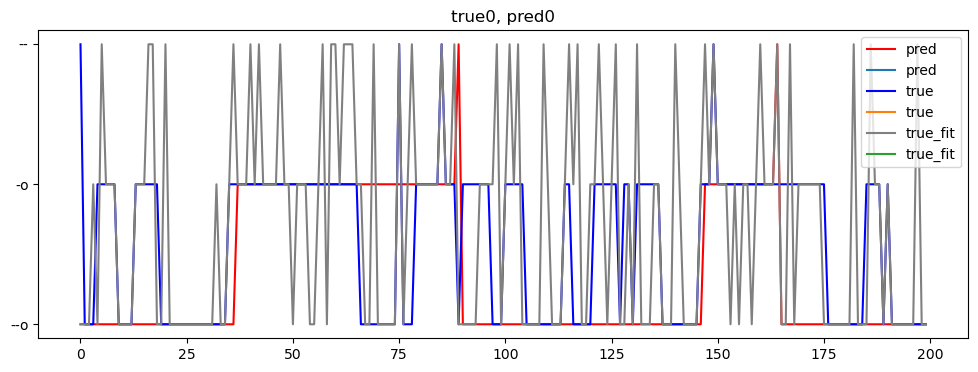

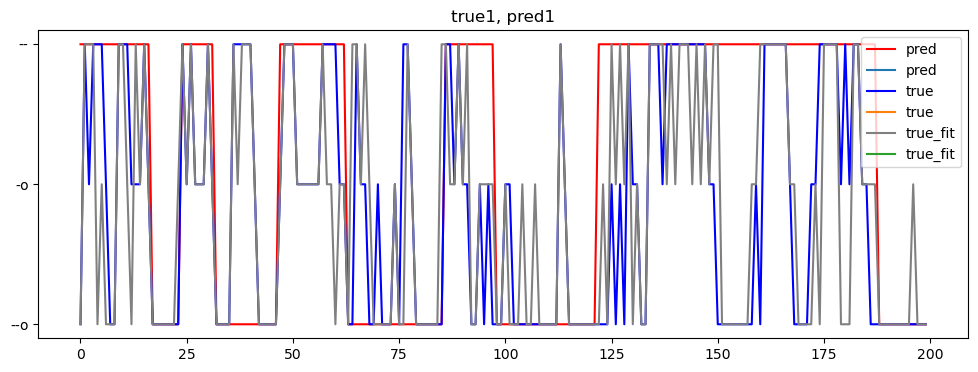

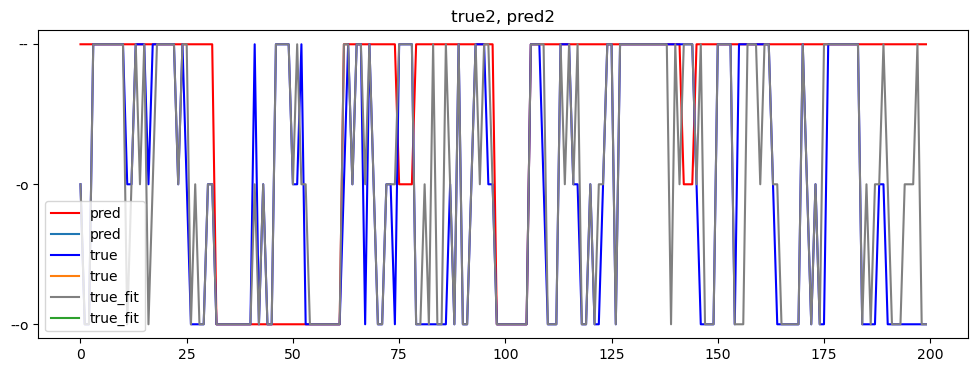

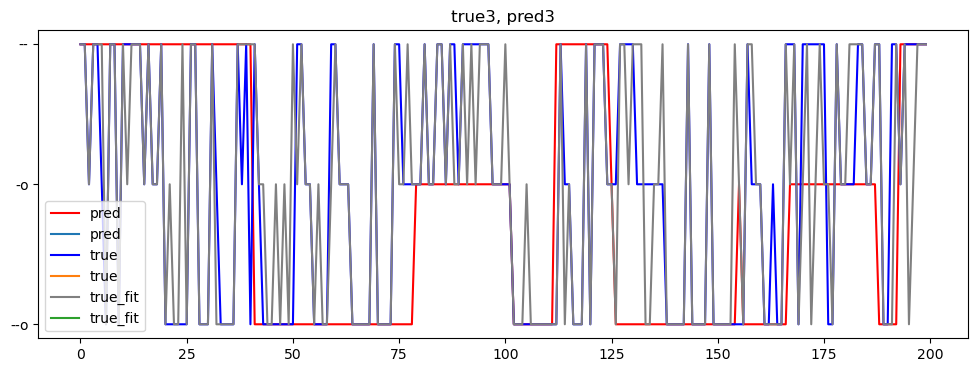

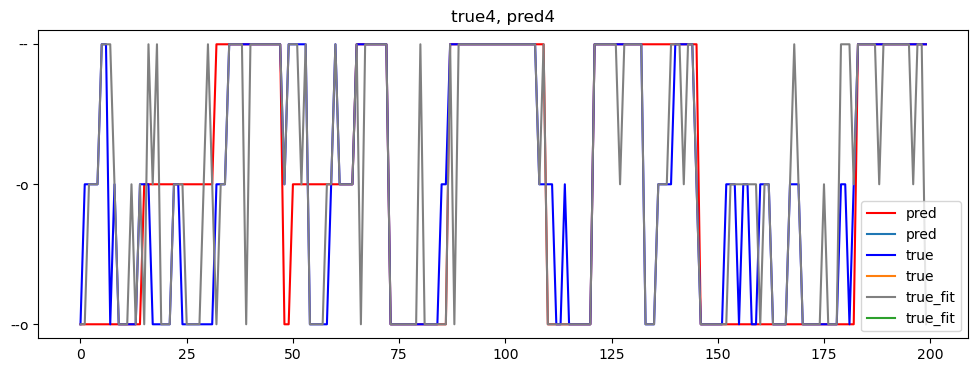

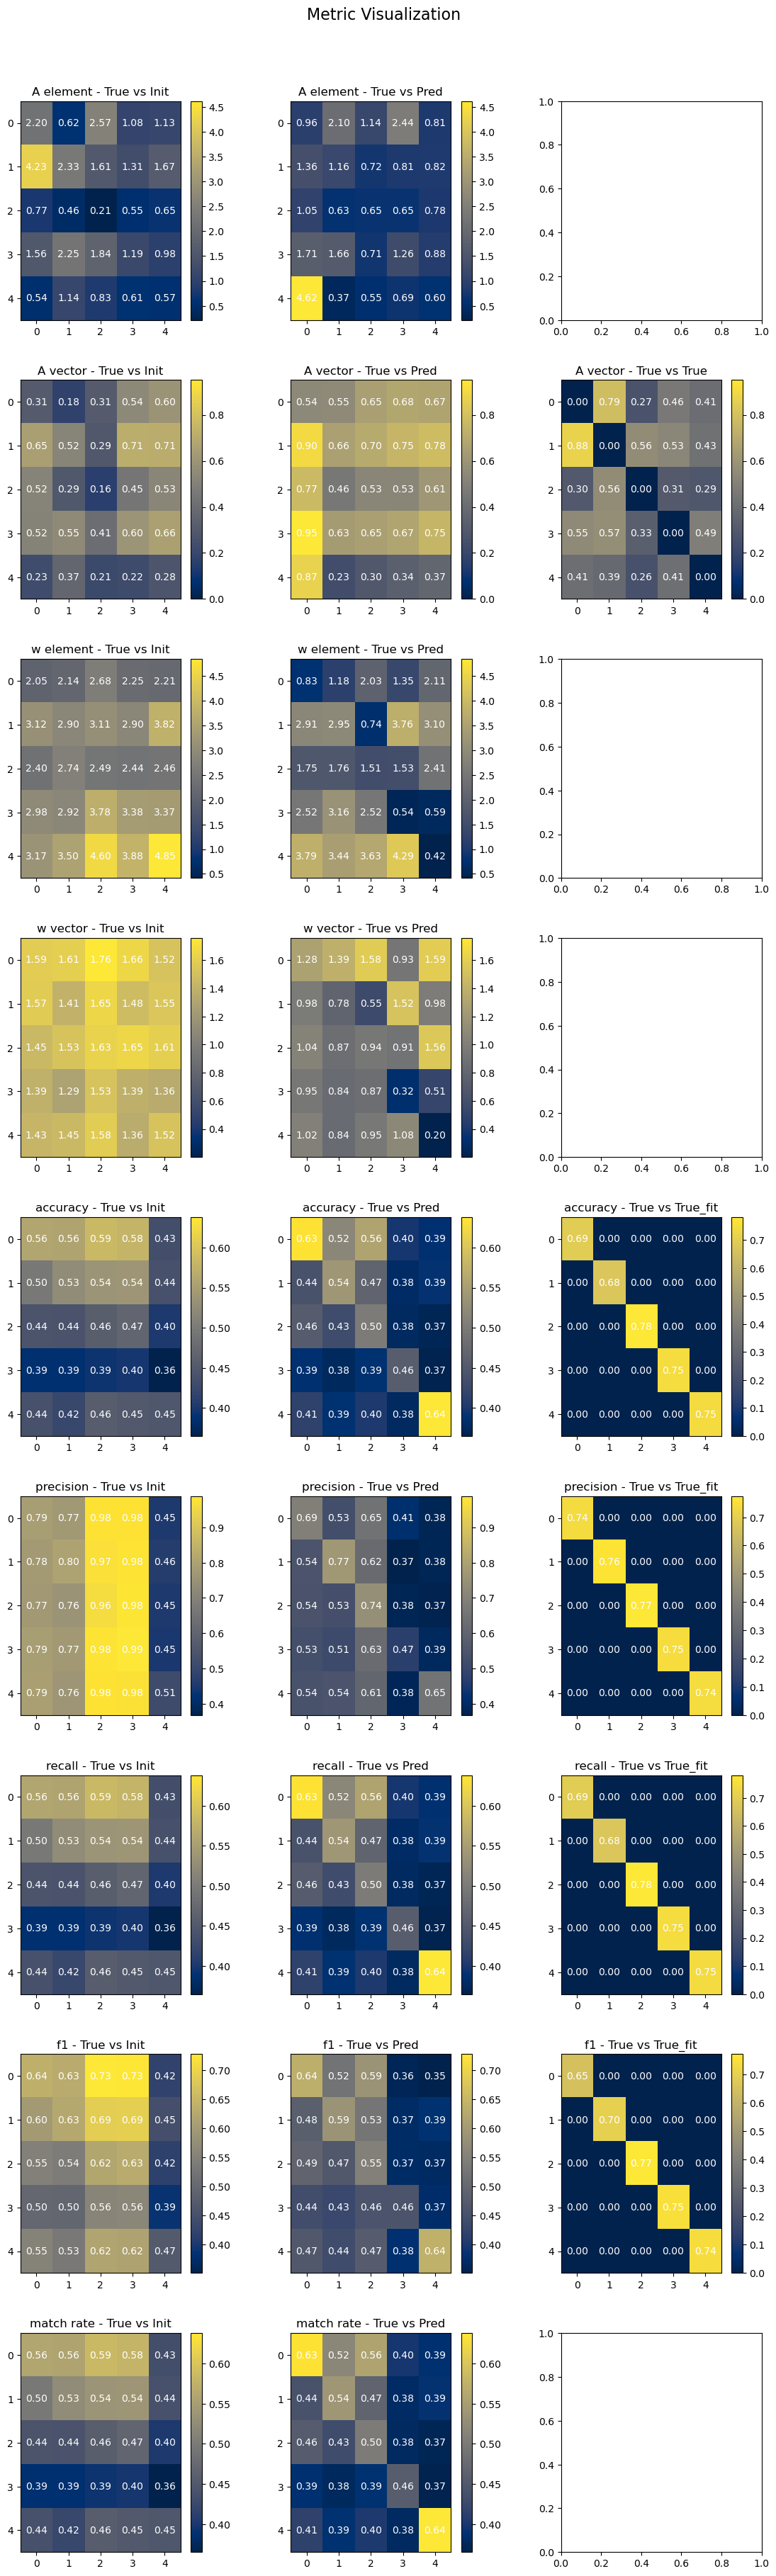

In [13]:
N=2000
dim_output=2
D = 7
K = 3
storage_all = analyze_stored_models(N, K, D, dim_output, True)
metric_comp(storage_all)

In [100]:
stored_models = load_models(N, K, D, dim_output)
len(stored_models)

2

In [101]:
stored_models[-1]['A_true'], stored_models[-1]['w_true']

([[0.826780573012175, 0.17321942698782508],
  [0.15069215540460948, 0.8493078445953905]],
 [[[-0.6144056589631639, -0.9331269085501558],
   [-0.15193810630486848, -0.4741497487751183],
   [-0.9771673952576779, -0.10613883032884619],
   [-0.5152602265348742, -0.46515558732404616],
   [-0.12129017947012011, -0.7091528034829568],
   [-0.15262319803253466, -0.8458002461079098],
   [-0.2331470187351109, -0.8702236668084977],
   [-0.43907891112117303, -0.5233525651859554]],
  [[0.19524769360908445, 0.13834841160095768],
   [0.4616079564620965, 0.30491871862461706],
   [0.24543787653725935, 0.4402632435896513],
   [0.1759432022988604, 0.020161918664657663],
   [0.3398104901443455, 0.13400383497283863],
   [0.730833775453932, 0.7181571650589087],
   [0.06637598288795121, 0.23333709759412502],
   [0.5174717838916882, 0.40172249423608686]]])

In [79]:
np.linalg.norm(np.array(stored_models[-1]['w_init']) - np.array(stored_models[-1]['w_true']))

4.325012788991858

In [58]:
np.linalg.norm(np.array(stored_models[-1]['w_pred']) - np.array(stored_models[-1]['w_true']))/ np.linalg.norm(np.array(stored_models[-1]['w_true']))

1.543989023002725

In [28]:
stored_models[-1]['A_init'], stored_models[-1]['A_pred'], stored_models[-1]['w_init'], stored_models[-1]['w_pred'], 

([[0.9073225728229511, 0.09267742717704885],
  [0.25552809991837105, 0.7444719000816289]],
 [[0.9999998741732289, 1.2582677120056294e-07],
  [0.0698942569065902, 0.9301057430934099]],
 [[[0.16574044750600403, 0.026382408767595678],
   [0.4835617996225685, 0.6825784312903849],
   [-0.6025971360564917, -0.22702720409112764],
   [-0.25154087021440663, -0.8497473981685795],
   [-0.338503481100366, -0.6410406291102104],
   [0.10464232295614262, 0.3483493336765151],
   [0.14058008612920547, -0.17149328483054083],
   [1.0, 1.0]],
  [[-0.6295641740302045, -0.2893701469226888],
   [-0.9773747617447808, 0.8504124710175647],
   [0.9638978291099898, -0.7815238679695575],
   [0.30625955604376154, 0.0682590236586389],
   [0.5696099702168322, 0.3992591258618572],
   [0.4918441306973529, -0.24643436542281583],
   [-0.9680163944158473, -0.7500898832984604],
   [1.0, 1.0]]],
 [[[-0.350977378334373, -0.2723972609047701],
   [-0.857587015546832, -0.007504091418107245],
   [-0.5704160340365307, -0.18854692

In [46]:
pred_states_seq[:500], true_states_seq[:500]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [43]:
w_perm, w_pred, w_true

(array([[[-0.11257246,  0.24450555],
         [ 0.21271409,  0.19833943],
         [ 0.05951402,  0.48396027],
         [ 0.37224352, -0.05437341],
         [ 0.48286522,  0.14002665],
         [ 0.39367117, -0.02581711],
         [ 0.09324444,  0.31290333],
         [ 0.24742158, -0.13942178]],
 
        [[-0.35097738, -0.27239726],
         [-0.85758702, -0.00750409],
         [-0.57041603, -0.18854693],
         [-0.42980931, -0.70789944],
         [-0.11757762, -0.58435819],
         [-0.56883973, -0.52801234],
         [-0.53549351, -0.75602101],
         [-0.62364866, -0.93025998]]]),
 array([[[-0.35097738, -0.27239726],
         [-0.85758702, -0.00750409],
         [-0.57041603, -0.18854693],
         [-0.42980931, -0.70789944],
         [-0.11757762, -0.58435819],
         [-0.56883973, -0.52801234],
         [-0.53549351, -0.75602101],
         [-0.62364866, -0.93025998]],
 
        [[-0.11257246,  0.24450555],
         [ 0.21271409,  0.19833943],
         [ 0.05951402,  0.483

In [40]:
np.linalg.norm(w_perm - w_true)/ np.linalg.norm(w_true)

1.6142472169721194

In [41]:
np.linalg.norm(np.array(stored_models[-1]['w_pred']) - np.array(stored_models[-1]['w_true']))/ np.linalg.norm(np.array(stored_models[-1]['w_true']))

0.31262729664125966

In [ ]:
N=500
dim_output=2
D = 7
K = 2


def metric_test(N, K, D, dim_output, num_models = 3, testN = 3000):
    '''
    ws = np.zeros((num_init, num_states, n_features + 1, obs_dim))
    As = np.zeros((num_init, num_states, num_states))
    pi0s = np.zeros((num_init, num_states))
    
    '''

    # true model params
    A_true_all = np.zeros((num_models, K, K))
    w_true_all = np.zeros((num_models, K, D+1, dim_output))
    pi0_true_all = np.zeros((num_models, K))
    true_states_seq_all = np.zeros((num_models, N))


    # init pred model params
    A_init_all = np.zeros_like(A_true_all)
    w_init_all = np.zeros_like(w_true_all)
    pi0_init_all = np.zeros_like(pi0_true_all)
    init_states_seq_all = np.zeros_like(true_states_seq_all)
    # pred(post training) model params
    A_pred_all = np.zeros_like(A_true_all)
    w_pred_all = np.zeros_like(w_true_all)
    pi0_pred_all = np.zeros_like(pi0_true_all)
    pred_states_seq_all = np.zeros_like(true_states_seq_all)
    

    for i in range(num_models):
        # Set up true model and generate data
        X, Y, _, A_true, w_true, pi0_true, m_true = gen_true_param(N, K, D, dim_output)

        X_test, Y_test, true_states_seq = m_true.generate_data(testN)
        A_true_all[i] = A_true
        w_true_all[i] = w_true
        pi0_true_all[i] = pi0_true
        true_states_seq_all[i] = true_states_seq.astype(int)

        # Fit a new model
        m = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
        A_init=m.transition_matrix
        w_init=m.w
        pi0_init  = m.pi0
        init_states_seq = m.mostprob_states(X_test, Y_test).astype(int)
        

        A_init_all[i] = A_init
        w_init_all[i] = w_init
        pi0_init_all[i] = pi0_init
        init_states_seq_all[i] = init_states_seq

        lls_pred,A_pred,w_pred,pi0_pred = m.fit(Y,X,A_init,w_init, pi0=pi0_init, fit_init_states=True)
        pred_states_seq = m.mostprob_states(X_test, Y_test)
        A_pred_all[i] = A_pred
        w_pred_all[i] = w_pred
        pi0_pred_all[i] = pi0_pred
        pred_states_seq_all[i] = pred_states_seq.astype(int)

    result = {
        'A_true_all': A_true_all,
        'w_true_all': w_true_all,
        'pi0_true_all': pi0_true_all,
        'true_states_seq_all': true_states_seq_all,
        'A_init_all': A_init_all,
        'w_init_all': w_init_all,
        'pi0_init_all': pi0_init_all,
        'init_states_seq_all': init_states_seq_all,
        'A_pred_all': A_pred_all,
        'w_pred_all': w_pred_all,
        'pi0_pred_all': pi0_pred_all,
        'pred_states_seq_all': pred_states_seq_all

    }
    # Analysis
    storage_all = np.zeros((num_models, num_models, 2, 9)) #2: init-0, pred-1 # (true, pred, true to init/pred, metric)
    
    for true_i in range(num_models):
        for pred_i in range(num_models):
            # extract the true params
            true_states_seq = true_states_seq_all[true_i]
            A_true = A_true_all[true_i]
            w_true = w_true_all[true_i]
            # extract the pred init params
            init_states_seq = init_states_seq_all[pred_i]
            A_init = A_init_all[pred_i]
            w_init = w_init_all[pred_i]
            # extract the pred params
            pred_states_seq = pred_states_seq_all[pred_i]
            A_pred = A_pred_all[pred_i]
            w_pred = w_pred_all[pred_i]

            # Permute the pred init states to align with true states
            init_states_seq = init_states_seq.astype(int)
            true_states_seq = true_states_seq.astype(int)
            pred_states_seq = pred_states_seq.astype(int)
            
            perm_init = find_permutation(init_states_seq, true_states_seq)
            init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(N)])
            A_perm_init = A_init[np.ix_(perm_init, perm_init)]
            w_perm_init = w_init[perm_init, :, :]
            # Permute the pred states to align with true states
            perm = find_permutation(pred_states_seq, true_states_seq)
            pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(N)])
            A_perm = A_pred[np.ix_(perm, perm)]
            w_perm = w_pred[perm, :, :]

            # Metric
            # Matrix comparison
            A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
            A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
            A_true2init_element = matrix_comp(A_true, A_init, metric="element")
            A_true2init_vector = matrix_comp(A_true, A_init, metric="vector")

            w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
            w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
            w_true2init_element = matrix_comp(w_true, w_init, metric="element")
            w_true2init_vector = matrix_comp(w_true, w_init, metric="vector")
            # State seq evaluation
            res_map_true2pred = evaluate_classification(pred_states_perm, true_states_seq)
            accuracy_true2pred = res_map_true2pred['accuracy'] #4
            precision_true2pred = res_map_true2pred['precision'] #5
            recall_true2pred = res_map_true2pred['recall'] #6
            f1_true2pred = res_map_true2pred['f1_score'] #7

            res_map_true2init = evaluate_classification(init_states_perm, true_states_seq)
            accuracy_true2init = res_map_true2init['accuracy']
            precision_true2init = res_map_true2init['precision']
            recall_true2init = res_map_true2init['recall']
            f1_true2init = res_map_true2init['f1_score']

            # matching rate of state seq
            mat_rate_true2pred = calculate_match_rate(pred_states_perm, true_states_seq) #8
            mat_rate_true2init = calculate_match_rate(init_states_perm, true_states_seq)

            # Storage
            storage_all[true_i, pred_i, 0] = np.array([A_true2init_element, A_true2init_vector, w_true2init_element, w_true2init_vector, \
                accuracy_true2init, precision_true2init, recall_true2init, f1_true2init, mat_rate_true2init])

            storage_all[true_i, pred_i, 1] = np.array([A_true2pred_element, A_true2pred_vector, w_true2pred_element, w_true2pred_vector, \
                accuracy_true2pred, precision_true2pred, recall_true2pred, f1_true2pred, mat_rate_true2pred])

    result['storage_all'] = storage_all
    return result
    

In [ ]:
result = metric_test(N, K, D, dim_output, num_models = 3)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


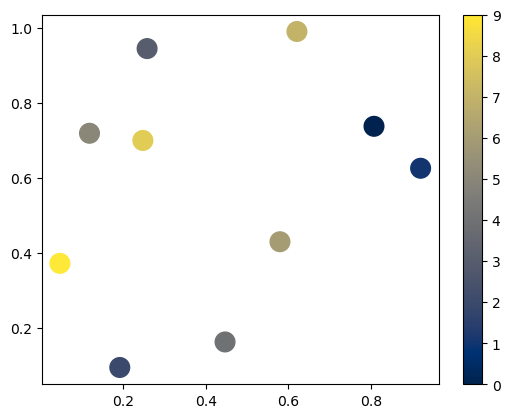

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.random.rand(10)
y = np.random.rand(10)
colors = np.arange(10)  # Categorical values

# Use a clearer categorical colormap
plt.scatter(x, y, c=colors, cmap="cividis", s=200)
plt.colorbar()
plt.show()


In [3]:
X1, Y1, true_states_seq1, A_true1, w_true1, pi0_true1 = gen_true_param(N, K, D, dim_output)
X2, Y2, true_states_seq2, A_true2, w_true2, pi0_true2 = gen_true_param(N, K, D, dim_output)

In [4]:
m1 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init1=m1.transition_matrix
w_init1=m1.w
lls_pred1,A_pred1,w_pred1,pi0_pred1 = m1.fit(Y1,X1,A_init1,w_init1, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [12]:
pred_states_seq1 = m1.mostprob_states(X1, Y1)

/data/users/weixuan/work/model/glmhmm/glmhmm.py:462: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))
/data/users/weixuan/work/model/glmhmm/glmhmm.py:464: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))


In [13]:
pred_states_seq1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
m2 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init2=m2.transition_matrix
w_init2=m2.w
lls_pred2,A_pred2,w_pred2,pi0_pred2 = m2.fit(Y2,X2,A_init2,w_init2, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [10]:
pred_states_seq2 = m2.mostprob_states(X2, Y2)

In [11]:
pred_states_seq2, 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [41]:
# Apply those metrics

# Permute states 
perm1 = find_permutation(pred_states_seq1, true_states_seq1)
pred_states_perm1 = np.array([perm1[pred_states_seq1[idx]] for idx in range(N)])
A_perm1 = A_pred1[np.ix_(perm1, perm1)]
w_perm1 = w_pred1[perm1, :, :]

In [38]:
w_true1

array([[[-0.19013904, -0.93677205],
        [-0.74692553, -0.593289  ],
        [-0.38786624, -0.16372864],
        [-0.53119145, -0.16631012],
        [-0.00254784, -0.98334534],
        [-0.65384389, -0.92761853],
        [-0.11354219, -0.67730854],
        [ 0.        ,  0.        ]],

       [[ 0.52831886,  0.92349298],
        [ 0.20323374,  0.7210474 ],
        [ 0.38743098,  0.84596426],
        [ 0.31790035,  0.22014139],
        [ 0.90133491,  0.65710237],
        [ 0.7213772 ,  0.04972955],
        [ 0.88076277,  0.67962071],
        [ 0.        ,  0.        ]]])

In [42]:
A_comp_element1 = matrix_comp(A_true1, A_perm1, metric="element")
A_comp_vector1 = matrix_comp(A_true1, A_perm1, metric="vector")
w_comp_element1 = matrix_comp(w_true1, w_perm1, metric="element")
w_comp_vector1 = matrix_comp(w_true1, w_perm1, metric="vector")


In [44]:
A_comp_element, A_comp_vector, w_comp_element1, w_comp_vector1

(0.6163059150382226, 0.4979360340877688, inf, 1.2950123981403079)

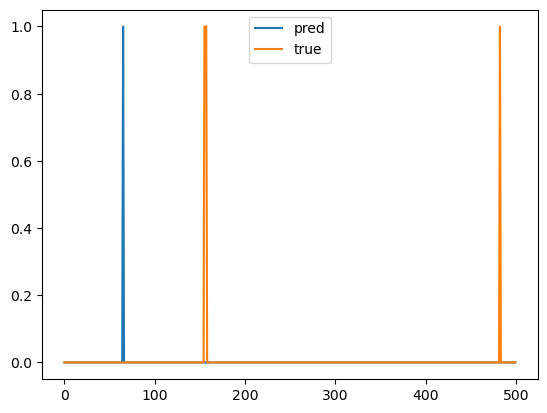

In [29]:
plt.plot(pred_states_perm1, label='pred')
plt.plot(true_states_seq1, label = 'true')
plt.legend()

In [27]:
perm2 = find_permutation(pred_states_seq2, true_states_seq2)
pred_states_perm2 = np.array([perm2[pred_states_seq2[idx]] for idx in range(N)])

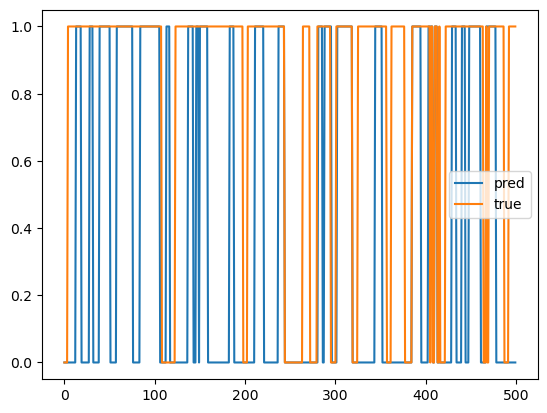

In [28]:
plt.plot(pred_states_perm2, label='pred')
plt.plot(true_states_seq2, label = 'true')
plt.legend()

In [ ]:
W_permuted = W[perm, :, :]